# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 6      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1856.2318115234375
iteration 0 loss 903369.375


iteration 5000 loss 14.528374671936035


iteration 10000 loss 11.145769119262695


iteration 15000 loss 5.306774139404297


iteration 20000 loss 0.04200145602226257


iteration 25000 loss 0.035265155136585236


iteration 30000 loss 0.005654017440974712


iteration 35000 loss 0.003150222124531865


iteration 40000 loss 0.0018920815782621503


iteration 45000 loss 0.0011615720577538013


iteration 50000 loss 0.15178744494915009


iteration 55000 loss 0.000500894442666322


iteration 60000 loss 0.00034124148078262806


iteration 65000 loss 0.00023818635963834822


iteration 70000 loss 0.00017197514534927905


iteration 75000 loss 0.0001251254725502804


iteration 80000 loss 9.251029405277222e-05


iteration 85000 loss 7.309378997888416e-05


iteration 90000 loss 0.02292538434267044


iteration 95000 loss 4.2723386286525056e-05


iteration 100000 loss 5.027395309298299e-05


iteration 105000 loss 0.0016158801736310124


iteration 110000 loss 0.004804391413927078


iteration 115000 loss 0.0033989818766713142


iteration 120000 loss 0.1272554248571396


iteration 125000 loss 6.971684342715889e-05


iteration 130000 loss 1.6909198166104034e-05


iteration 135000 loss 1.5856554455240257e-05


iteration 140000 loss 1.4427819223783445e-05


iteration 145000 loss 4.57458954770118e-05


iteration 150000 loss 1.668663571763318e-05


iteration 155000 loss 3.2887426641536877e-05


iteration 160000 loss 1.708835225144867e-05


iteration 165000 loss 1.4755050870007835e-05


iteration 170000 loss 0.000150849053170532


iteration 175000 loss 1.4273291526478715e-05


iteration 180000 loss 0.0008530599297955632


iteration 185000 loss 1.3062220205029007e-05


iteration 190000 loss 1.1808549970737658e-05


iteration 195000 loss 1.216492000821745e-05


iteration 200000 loss 0.09211049973964691


iteration 205000 loss 1.2217864423291758e-05


iteration 210000 loss 1.1923716556339059e-05


iteration 215000 loss 1.196732137032086e-05


iteration 220000 loss 1.5268065908458084e-05


iteration 225000 loss 1.1935293514397927e-05


iteration 230000 loss 1.1009433364961296e-05


iteration 235000 loss 1.2338962733338121e-05


iteration 240000 loss 1.555395283503458e-05


iteration 245000 loss 1.326248275290709e-05


iteration 250000 loss 1.0981181731040124e-05


iteration 255000 loss 1.1396615263947751e-05


iteration 260000 loss 5.328483530320227e-05


iteration 265000 loss 1.2977507140021771e-05


iteration 270000 loss 1.8743281543720514e-05


iteration 275000 loss 0.009172722697257996


iteration 280000 loss 0.0024465147871524096


iteration 285000 loss 1.3272684554976877e-05


iteration 290000 loss 9.74677186604822e-06


iteration 295000 loss 1.3069567103229929e-05


iteration 300000 loss 1.1369193998689298e-05


iteration 305000 loss 0.001067837351001799


iteration 310000 loss 1.0821705473063048e-05


iteration 315000 loss 0.0003503667248878628


iteration 320000 loss 1.117248393711634e-05


iteration 325000 loss 9.149859579338226e-06


iteration 330000 loss 1.0864935575227719e-05


iteration 335000 loss 0.00010123436368303373


iteration 340000 loss 1.0364397894591093e-05


iteration 345000 loss 1.3964213394501712e-05


iteration 350000 loss 9.91587876342237e-06


iteration 355000 loss 1.057085955835646e-05


iteration 360000 loss 8.677532605361193e-06


iteration 365000 loss 9.905466868076473e-06


iteration 370000 loss 9.449332537769806e-06


iteration 375000 loss 8.743915714148898e-06


iteration 380000 loss 0.0013008132809773088


iteration 385000 loss 1.1855482625833247e-05


iteration 390000 loss 1.001902091957163e-05


iteration 395000 loss 8.673369848111179e-06


iteration 400000 loss 8.459883247269318e-06


iteration 405000 loss 0.03716377913951874


iteration 410000 loss 0.0014003325486555696


iteration 415000 loss 1.4676561477244832e-05


iteration 420000 loss 8.934899597079493e-06


iteration 425000 loss 8.747776519157924e-06


iteration 430000 loss 8.319912922161166e-06


iteration 435000 loss 9.15399596124189e-06


iteration 440000 loss 8.105589586193673e-06


iteration 445000 loss 8.33776175568346e-06


iteration 450000 loss 8.280393558379728e-06


iteration 455000 loss 7.65958429838065e-06


iteration 460000 loss 7.819709935574792e-06


iteration 465000 loss 0.0010219214018434286


iteration 470000 loss 0.002377008553594351


iteration 475000 loss 1.3648214917338919e-05


iteration 480000 loss 0.07150079309940338


iteration 485000 loss 9.955857967725024e-05


iteration 490000 loss 9.69622669799719e-06


iteration 495000 loss 8.26079303806182e-06


L2 loss -- Plot

loss -35.13438034057617


loss -200.59725952148438


loss -298.94696044921875


loss -380.9298400878906


loss -455.4067077636719


loss -522.0591430664062


loss -578.7123413085938


loss -623.8831787109375


loss -656.2770385742188


loss -678.3900146484375


loss -693.9043579101562


loss -704.7391357421875


loss -712.1417236328125


loss -716.9951171875


loss -719.9732666015625


loss -721.6389770507812


loss -722.465087890625


loss -722.81640625


loss -722.9388427734375


loss -722.9716796875


loss -722.9779663085938


loss -722.9786987304688


loss -722.978759765625


loss -722.9788208007812


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.9788208007812


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.978759765625


loss -722.9788208007812


loss -722.978759765625


final mse:  4.623361415934113e-10
max, min: 5.7844157 -6.8589153
loss -35.13438034057617


loss -204.6858367919922


loss -305.6558837890625


loss -390.7265930175781


loss -469.61065673828125


loss -542.5126953125


loss -607.4920654296875


loss -661.8812255859375


loss -704.5


loss -735.9444580078125


loss -758.4285888671875


loss -773.936279296875


loss -784.2037963867188


loss -790.7699584960938


loss -794.829833984375


loss -797.2049560546875


loss -798.475830078125


loss -799.0759887695312


loss -799.31689453125


loss -799.3955078125


loss -799.4152221679688


loss -799.4187622070312


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


loss -799.419189453125


final mse:  3.5600367098709285e-10
max, min: 6.6050763 -7.115871


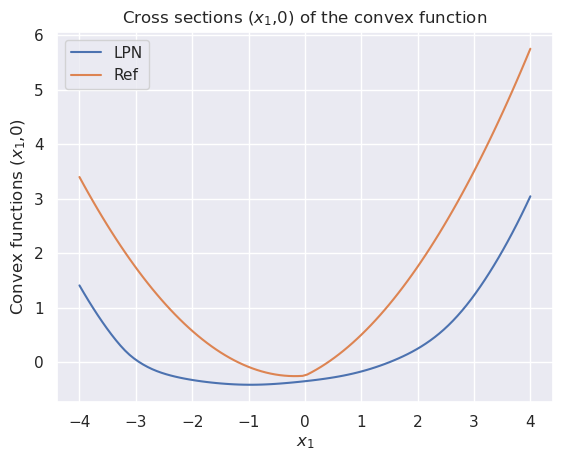

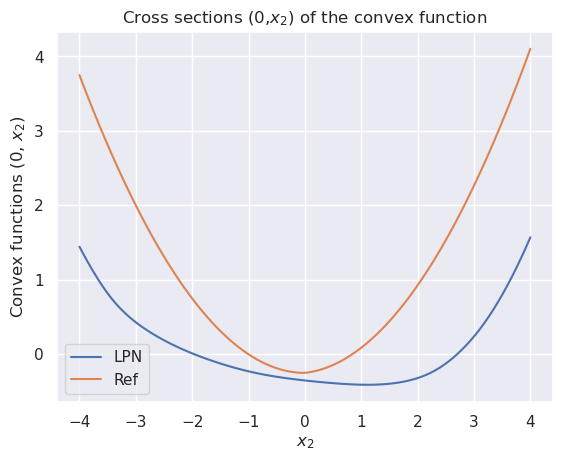

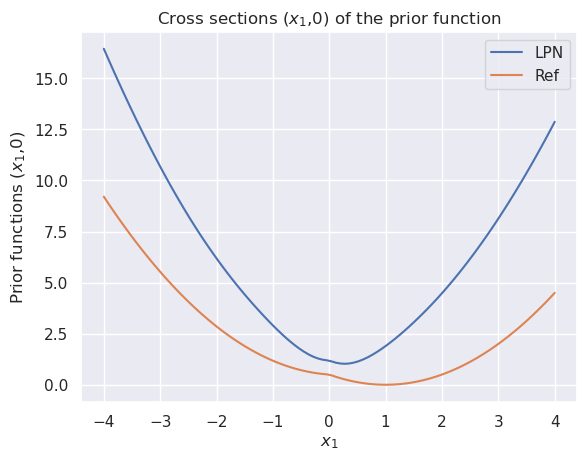

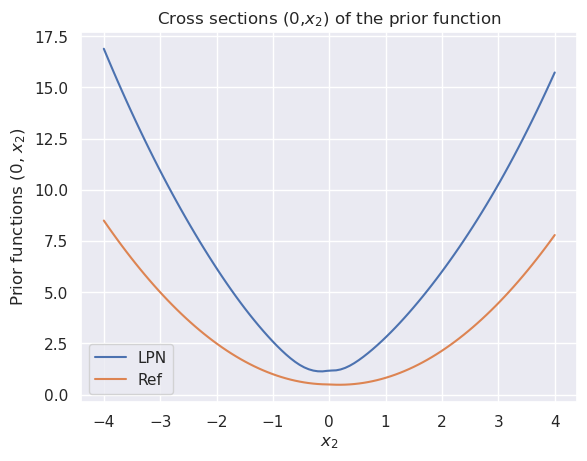

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1527.2542724609375
iteration 0 loss 186597.65625


iteration 5000 loss 3.9245147705078125


iteration 10000 loss 1.9575302600860596


iteration 15000 loss 0.9709562063217163


iteration 20000 loss 0.09070529788732529


iteration 25000 loss 0.043358318507671356


iteration 30000 loss 0.02716338075697422


iteration 35000 loss 0.018763689324259758


iteration 40000 loss 0.013974044471979141


iteration 45000 loss 0.011008992791175842


iteration 50000 loss 0.00882671307772398


iteration 55000 loss 0.007232927717268467


iteration 60000 loss 0.006011308170855045


iteration 65000 loss 0.005060145631432533


iteration 70000 loss 0.004399512428790331


iteration 75000 loss 0.0037575948517769575


iteration 80000 loss 0.0032453907188028097


iteration 85000 loss 0.002818317385390401


iteration 90000 loss 0.00246637687087059


iteration 95000 loss 0.0021742370445281267


iteration 100000 loss 0.0019298053812235594


iteration 105000 loss 0.0017089362954720855


iteration 110000 loss 0.0015198951587080956


iteration 115000 loss 0.001361280563287437


iteration 120000 loss 0.0012437315890565515


iteration 125000 loss 0.001096404273994267


iteration 130000 loss 0.0009894983377307653


iteration 135000 loss 0.0008969111950136721


iteration 140000 loss 0.0010036679450422525


iteration 145000 loss 0.0007471494609490037


iteration 150000 loss 0.000669050554279238


iteration 155000 loss 0.0006107956869527698


iteration 160000 loss 0.000553853518795222


iteration 165000 loss 0.02519823983311653


iteration 170000 loss 0.0004594774218276143


iteration 175000 loss 0.00042197617585770786


iteration 180000 loss 0.0003867097257170826


iteration 185000 loss 0.0008801541989669204


iteration 190000 loss 0.0003255822230130434


iteration 195000 loss 0.0002967682376038283


iteration 200000 loss 0.0003654712054412812


iteration 205000 loss 0.00025126044056378305


iteration 210000 loss 0.0002322202199138701


iteration 215000 loss 0.0002131024084519595


iteration 220000 loss 0.00019690395856741816


iteration 225000 loss 0.00018143192573916167


iteration 230000 loss 0.0026253892574459314


iteration 235000 loss 0.00015581723710056394


iteration 240000 loss 0.00021979922894388437


iteration 245000 loss 0.0001339259761152789


iteration 250000 loss 0.00012388084724079818


iteration 255000 loss 0.00013539691281039268


iteration 260000 loss 0.00010885023948503658


iteration 265000 loss 0.018846092745661736


iteration 270000 loss 9.319672244600952e-05


iteration 275000 loss 8.654970588395372e-05


iteration 280000 loss 8.187432104023173e-05


iteration 285000 loss 7.57508969400078e-05


iteration 290000 loss 7.09940868546255e-05


iteration 295000 loss 6.703111284878105e-05


iteration 300000 loss 6.222756928764284e-05


iteration 305000 loss 5.909751416766085e-05


iteration 310000 loss 6.448513158829883e-05


iteration 315000 loss 6.590639532078058e-05


iteration 320000 loss 4.919926868751645e-05


iteration 325000 loss 4.850105688092299e-05


iteration 330000 loss 4.3576263124123216e-05


iteration 335000 loss 4.25409380113706e-05


iteration 340000 loss 0.015495422296226025


iteration 345000 loss 3.768341048271395e-05


iteration 350000 loss 3.526773798512295e-05


iteration 355000 loss 3.353453939780593e-05


iteration 360000 loss 3.204978202120401e-05


iteration 365000 loss 3.122176349279471e-05


iteration 370000 loss 2.9266386263770983e-05


iteration 375000 loss 2.8246025976841338e-05


iteration 380000 loss 0.0027898463886231184


iteration 385000 loss 2.5496494345134124e-05


iteration 390000 loss 2.43749309447594e-05


iteration 395000 loss 2.3879700165707618e-05


iteration 400000 loss 0.00024398665118496865


iteration 405000 loss 2.1681058569811285e-05


iteration 410000 loss 0.0004288993659429252


iteration 415000 loss 2.0099809262319468e-05


iteration 420000 loss 1.9501512724673375e-05


iteration 425000 loss 2.8709529942716472e-05


iteration 430000 loss 1.8381449990556575e-05


iteration 435000 loss 1.7766629753168672e-05


iteration 440000 loss 1.821392470446881e-05


iteration 445000 loss 0.011916189454495907


iteration 450000 loss 1.646380769670941e-05


iteration 455000 loss 2.0130391931161284e-05


iteration 460000 loss 0.01866120472550392


iteration 465000 loss 0.015398659743368626


iteration 470000 loss 0.0011179220164194703


iteration 475000 loss 1.4214580914995167e-05


iteration 480000 loss 0.017055587843060493


iteration 485000 loss 1.3879689504392445e-05


iteration 490000 loss 1.3317295270098839e-05


iteration 495000 loss 0.0005671446560882032


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


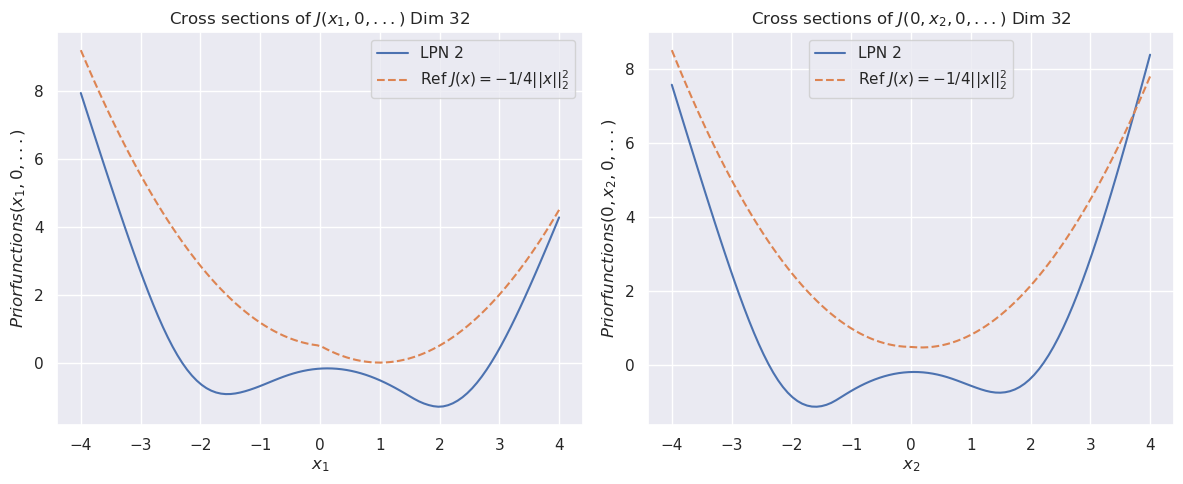

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)